In [534]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
from scipy import interpolate


In [535]:
R = 8.314 # Sets R(gas constant) value in [J/(mol-K)]

In [536]:
def read_ads_data(mof, temperature): # MOF name and temp data was recorded 
    ads_data = pd.read_csv('data/{}_{}C.csv'.format(mof, temperature)) # Reads the isotherm 
    
    if (ads_data['RH[%]'])[0] == 0:
        ads_data = ads_data.drop(0) # Drops the first row if the first RH value is 0
        ads_data = ads_data.reset_index(drop=True)

    if ads_data['RH[%]'].iloc[-1] > 1:
        ads_data['P/P_0'] = ads_data['RH[%]'] / 100  # Converts the relative humidity to P/P_0 (from % to decimal)
    else:
        ads_data['P/P_0'] = ads_data['RH[%]']  # Converts the relative humidity to P/P_0 (changes name )


    ads_data["A"] = -R * (temperature+273.15) * np.log(ads_data['P/P_0']) # Calculates Polanyi adsorption potential for every point on the graph 
    
    ads_data = ads_data.drop(columns=['RH[%]']) # Gets rid of the Humidity column 
    return ads_data

In [538]:
def characteristic_curve (ads_data): # does the above lines in a function 

    ads_data = ads_data.sort_values('A') # Sorts the MOF 801 data by A values so it can be plotted and the curve can be calculated 

    n_of_A = interpolate.PchipInterpolator(ads_data['A'], ads_data['Water Uptake [kg kg-1]']) # Finds the equation of the characteristic curve 

    return n_of_A

In [539]:
def calculate_water(T,P_over_P_0,n_of_A): # Given a T and P/P_0 (RH as a fraction of 1, not a percent) 
    A = -R * (T+273.15) * np.log(P_over_P_0) # Calculate the Polanyi potential 
    Rate_H2O = n_of_A(A) # Plot A on the characteristic curve and find the rate of water adsorption 
    
    return(Rate_H2O.item()) # Return amount of water adsorption 

In [540]:
#Source for weather data for Phoenix from 2020-2021
#https://weathersight.io/timeseries

df_weather = pd.read_csv('data/Phoenix_weather_edited_final.csv') # Import csv file that contains weather data 

In [541]:
def weekly_data(week): # Given a week find the weather data 
    
    df_week = df_weather['Week'] == week # narrow the dataframe to the given week 
    T_high = df_weather[df_week]['T_max_mean[C]'].item() # looking into the weekly dataframe, pull data value 
    T_low = df_weather[df_week]['T_min_mean[C]'].item() # ""
    Dewp_high = df_weather[df_week]['Max_dewp[C]'].item() # "" 
    Dewp_low = df_weather[df_week]['Min_dewp[C]'].item() # ""
    
    return T_high, T_low, Dewp_high, Dewp_low                        

In [542]:
#Find the saturated vapor pressure from temp and dewp 
#source for formula 
#https://www.weather.gov/media/epz/wxcalc/vaporPressure.pdf

def pressure_calculations(T,T_dew): # Given a temperature and a dewpoint temp from the weather data 
    
    P_0 = 6.11 * 10**((7.5*T)/(237.3+T)) #calculate saturation pressure 
    P = 6.11 * 10**((7.5*T_dew)/(237.3+T_dew)) # calculate actual pressure
    P_over_P_0 = P/P_0 # calculate P/P_0, relative humidity as a fraction of 1 
    
    return P_over_P_0 # this should be the only value we need out of this function 

In [543]:
 
def water_daily(week,kg_MOF,n_of_A): # find mass of water depending on weekly avg weather and mass MOF
    
    T_high, T_low, Dewp_high, Dewp_low = weekly_data(week) # extract weather data 

    
    P_over_P_0_high = pressure_calculations(T_high, Dewp_high) # calculate humidity during daily high
    
    P_over_P_0_low = pressure_calculations(T_low, Dewp_low) # calculate humidity during daily low
    
    A_low = -R * (T_low+273.15) * np.log(P_over_P_0_high) # calculate polanyi potential during daily high
    
    A_high = -R * (T_high+273.15) * np.log(P_over_P_0_low) # calculate polanyi potential during daily low
    
    high_water = calculate_water(T_high, P_over_P_0_high,n_of_A)  # calculate adsorption value during daily high
    
    low_water = (calculate_water(T_low, P_over_P_0_low,n_of_A)) # calculate adsorption value during daily low (should be higher than during daily high)
    
    water_rate = low_water - high_water # compare the high and low values to find amount of water kicked off by MOF over the course of a day per kg MOF 
    
    water_mass = water_rate * kg_MOF # multiply by kg MOF to find absolute mass of water produced per day under weekly avg conditions 
    
    #print('The mass of water collected by the MOF per day during week', week, 'is',round(water_mass,4),'[kg/day]')

    return water_mass, T_high, T_low

In [544]:
# use water adsorption data and conditions to generate new isotherm curves by temp 
# given T, calculate all A and find ads point, then plot ads vs RH 

def new_isotherm(T,n_of_A):
    
    ads_values = []
    RH_values = []
    
    for i in range(100):
       
        A = -R * (T+273.15) * np.log((i+1)/100) # calculates polanyi potential for given T at given P/P_0

        ads = n_of_A(A).item() # finds ads value for given A value 

        RH_current = i+1

        ads_values.append(ads) # add these adsorption values to a list 

        RH_values.append(RH_current)
    
    df_new_isotherm = pd.DataFrame(ads_values, columns=['Adsorption value [kg H2O / kg MOF]']) # create dataframe with the adsorption data 

    df_new_isotherm.insert(0,'Relative Humidity',RH_values) # add RH to the dataframe 

    # plots the new isotherm 
    plt.scatter(df_new_isotherm['Relative Humidity'], df_new_isotherm['Adsorption value [kg H2O / kg MOF]'], label = (T))
    plt.xlabel('Relative Humidity [%]')
    plt.ylabel('Adsorption value [kg H2O / kg MOF]')
    plt.xlim(xmin=0)
    plt.legend()
    

In [545]:
def Optimize_per_week(mof, data_temp, week, kg_MOF): # using MOF data at MOF name mof and data temperature temp, calculate water from given week and mass MOF

    ads_data = read_ads_data(mof, data_temp) # pull the file and calculate A values 

    n_of_A = characteristic_curve(ads_data) # create characteristic curve 

    water_mass, T_high, T_low = water_daily(week,kg_MOF,n_of_A) # pull the water mass and high and low temps to see isotherms 

    new_isotherm(T_high, n_of_A) # view high temp isotherm 
    new_isotherm(T_low, n_of_A) # view low temp isotherm 
    plt.title('Difference in isotherms by daily high and low avg temp')


    return water_mass # should be what is being optimized, changing kg_MOF for a given MOF and week  
    

    


0.32872422192321626

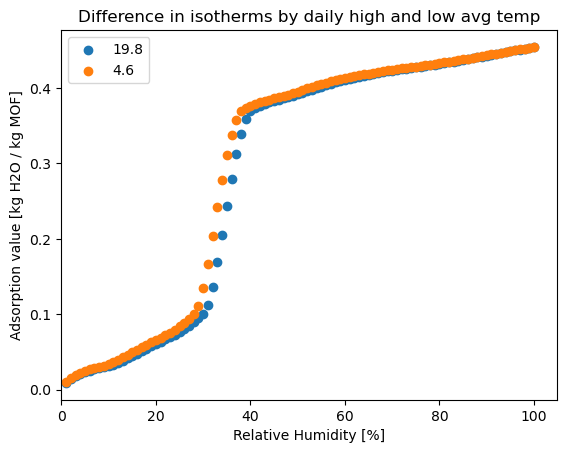

In [557]:
Optimize_per_week('UiO_66',20,1,1)

In [548]:
def view_isotherm(mof, data_temp): # view isotherm for a given MOF and temperature 
    
    ads_data = read_ads_data(mof, data_temp) # pull the file and calculate A values 
    
    plt.title('Isotherm for {} at {}C'.format(mof, data_temp))
    plt.scatter(ads_data['P/P_0'], ads_data['Water Uptake [kg kg-1]'])
    plt.xlabel('P/P_0')
    plt.ylabel('Water Uptake [kg/kg]')
    
    

In [549]:
def view_characteristic_curve(mof, data_temp): # view the characteristic curve for a given MOF and temperature 
    
    ads_data = read_ads_data(mof, data_temp) # pull the file and calculate A values 
    
    n_of_A = characteristic_curve(ads_data) # create characteristic curve 
    
    
    plt.scatter(ads_data['A'], ads_data['Water Uptake [kg kg-1]'])
    plt.xlabel('A')
    plt.ylabel('Water Uptake [kg/kg]')
    plt.title('Characteristic curve for {} at {}C'.format(mof, data_temp))
    plt.plot(ads_data['A'], n_of_A(ads_data['A']), label='Characteristic curve')

In [550]:
def view_mof (mof, data_temp): # view the isotherm and characteristic curve for a given MOF and temperature 
    
    view_isotherm(mof, data_temp)
    plt.show()
    view_characteristic_curve(mof, data_temp)
    plt.legend()

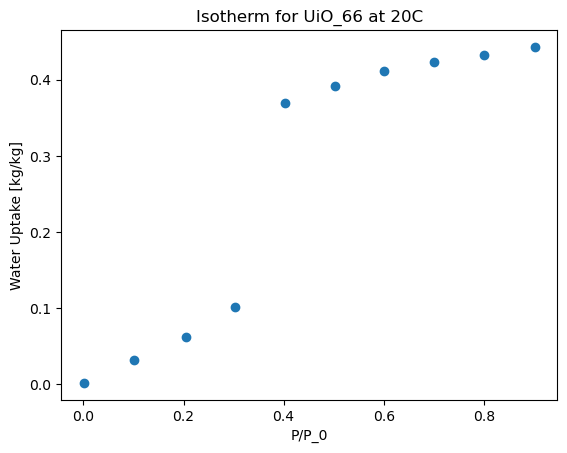

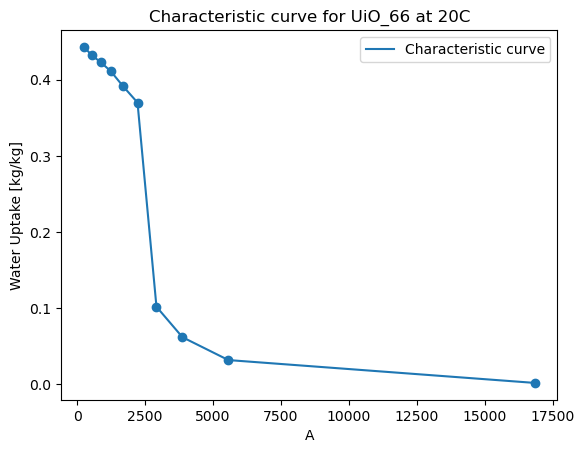

In [551]:
view_mof('UiO_66', 20)